# Notebook to test out three-subdomain HW fits
by Mike, 2021

Plan is to explore whether having the variable sub-domain fits enabled improves results on the Meade River

In [1]:
import os,sys

# 1) add FLaPE-Byrd repository location (pulled from github.com/mikedurand/flape-byrd) to the path
sys.path.append('/Users/mtd/GitHub/FLaPE-Byrd/') 

# 2) import needed modules
from ReachObservations import ReachObservations
from ReachTruth import ReachTruth
from RiverIO import RiverIO
from FlowLawCalibration import FlowLawCalibration
from Domain import Domain
from pprint import pprint
from FlowLaws import MWACN,MWAPN,AHGW,AHGD,MWHCN,MWAVN,MOMMA

import pandas as pd
import numpy as np

from IPython.display import display, Markdown

import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
# 3) provide path to data folders and read directory contents

DataDir='/Users/mtd/Data/ArcticDEMHydro/reach_averages/'

IncludeList=['gage66']
RiverNames=['Meade']

**Running gage66**

`gtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 308, CG iterations: 78, optimality: 6.55e-09, constraint violation: 7.82e-14, execution time: 0.13 s.
height-width fit for set breakpoints


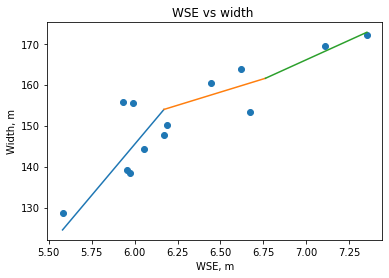

The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 279, CG iterations: 179, optimality: 3.14e-02, constraint violation: 0.00e+00, execution time: 3.9e+01 s.
`gtol` termination condition is satisfied.
Number of iterations: 56, function evaluations: 315, CG iterations: 86, optimality: 9.85e-09, constraint violation: 2.84e-14, execution time:  0.1 s.
height-width fit for nested optimization


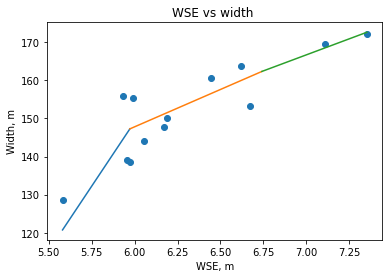

SWOT-style area calculations
Optimize Failed! Setting parameters to nan
Optimize Failed! Setting parameters to nan


In [3]:
DataDirContents=os.scandir(DataDir)

ConstrainHW=True #set to true to compute self-constrained height-width data
CalcAreaFit=2 # set to 1 for the quicker option - use equally-spaced HW breakpoints
dAOpt=1 #set to 0 to use MetroMan-style. set to 1 to use SWOT style
Verbose=True
ShowEverything=False

RunData={}

for entry in DataDirContents:
    if entry.is_dir() and entry.name in IncludeList:        
        BaseDir=DataDir + entry.name + '/'
        
        display(Markdown("**Running "+entry.name+"**"))
        
        IncludeList.index(entry.name)
        RiverName=RiverNames[IncludeList.index(entry.name)]        
        
        #4) Read data and set up data objects
        IO=RiverIO('MetroManTxt',obsFname=BaseDir+'SWOTobs.txt',truthFname=BaseDir+'truth.txt')        
        D=Domain(IO.ObsData)
        Obs=ReachObservations(D,IO.ObsData,ConstrainHW,CalcAreaFit,dAOpt,Verbose)
        Truth=ReachTruth(IO.TruthData)
                
        Variants=['AHGW', 'AHGD','HeightManning','Constant-n','PowerLaw-n','MWAVN','MOMMA']        
        
        ReachDict={}
        ReachDict['dA']=Obs.dA[0,:]
        ReachDict['w']=Obs.w[0,:]
        ReachDict['S']=Obs.S[0,:]
        ReachDict['H']=Obs.h[0,:]            
        ReachDict['Qtrue']=Truth.Q[0,:]

        FlowLawVariants={}
        FlowLawVariants['AHGW']=AHGW(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])           
        FlowLawVariants['AHGD']=AHGD(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])          
        FlowLawVariants['HeightManning']=MWHCN(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])
        FlowLawVariants['Constant-n']=MWACN(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])           
        FlowLawVariants['PowerLaw-n']=MWAPN(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])          
        FlowLawVariants['MWAVN']=MWAVN(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])  
        FlowLawVariants['MOMMA']=MWAVN(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])                                       
        
        cal={} #make a dictionary of results, keyed off the flow law variant name
        for variant in FlowLawVariants.keys():               
            flow_law_cal=FlowLawCalibration(D,ReachDict['Qtrue'],FlowLawVariants[variant])
            flow_law_cal.CalibrateReach(verbose=False,suppress_warnings=True)
            cal[variant]=flow_law_cal      

            if ShowEverything:
                display(Markdown(variant))
                cal[variant].PlotTimeseries()
                cal[variant].PlotScatterplot()
                                    
        #8 Collect run data
        ThisRunData={
           "id":entry.name,                          
           "cal":cal
        }
        RunData[RiverName]=ThisRunData            

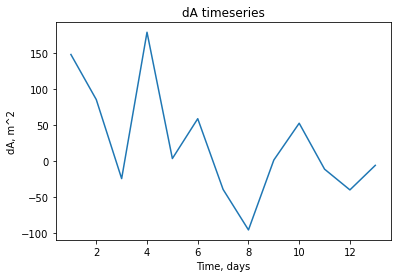

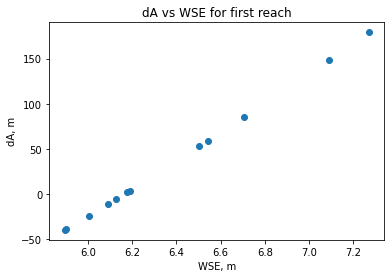

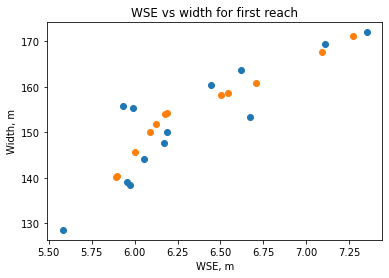

In [4]:
# check out how the cross-sectional area calculations look
Obs.plotdA()
Obs.plotHdA()
Obs.plotHW()

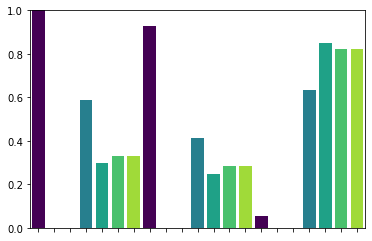

In [5]:
# plot up accuracy by flow law
fig,ax = plt.subplots()

plasma=cm.get_cmap('viridis', 64)
barcolors=plasma(np.arange(0,1,1/len(Variants)))

barcolors_all=np.block([[barcolors],[barcolors],[barcolors]])

ydata_nRMSE=[]
ydata_NSE=[]    
ydata_KGE=[]
ydata_nMAE=[]

for Variant in Variants:
    ydata_nRMSE.append(RunData[RiverName]['cal'][Variant].Performance.nRMSE)
    ydata_nMAE.append(RunData[RiverName]['cal'][Variant].Performance.nMAE)
    ydata_KGE.append(RunData[RiverName]['cal'][Variant].Performance.KGE)    
    ydata_NSE.append(RunData[RiverName]['cal'][Variant].Performance.NSE)    
    
ydata=ydata_nRMSE+ydata_nMAE+ydata_KGE     

xdata=np.arange(0,3*len(Variants))
hplt=ax.bar(xdata,ydata,color=barcolors_all,tick_label='')    
ax.set_ylim(0,1)
ax.set_xlim(-.5,3*len(Variants)-0.5)    
#ax_reach.set_title(RiverName)
#ax_reach.bar_label(hplt, fmt='%.2f')
plt.show()